<a href="https://colab.research.google.com/github/AminJ1989/LSTM/blob/main/FOREX_Next_Day_LSTM_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
pip install yfinance

In [46]:
pip install backtrader

In [30]:
import numpy as np
import pandas as pd
from statistics import fmean
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import yfinance
import pandas_datareader as pdr
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime, timedelta
import backtrader as bt
from keras.layers import Dropout

Function Defintion(s)

In [34]:
# split a univariate sequence into samples for training LSTM
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# Split a univariate sequence into samples for prediction of the next day
def split_sequences_last_n_steps(data, n_steps):
    X = []

    # Check if the input data is a DataFrame
    if isinstance(data, pd.DataFrame):
        # Convert the DataFrame to a NumPy array
        sequences = data.to_numpy()

        # Check if the dataframe has enough data points
        if len(sequences) < n_steps:
            raise ValueError("The number of data points is less than n_steps.")

        # Extract the last n_steps values as the input sequence
        input_sequence = sequences[-n_steps:]

        X.append(input_sequence)

    # Check if the input data is a list
    elif isinstance(data, list):
        # Check if the list has enough data points
        if len(data) < n_steps:
            raise ValueError("The number of data points is less than n_steps.")

        # Extract the last n_steps values as the input sequence
        input_sequence = data[-n_steps:]

        X.append(input_sequence)

    else:
        raise TypeError("Input data must be a DataFrame or a list.")

    return np.array(X)

Import Data¶


In [32]:
# Calculate the start date as "2012-01-01"
start_date = "2012-01-01"

# Calculate the end date as "2015-01-01"
end_date = "2015-01-01"

# Define the list of currency pairs you want to download
currency_pairs = ['EURUSD=X']

# Download the exchange rate data using yfinance
df = yfinance.download(currency_pairs, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


Train, Validate

(681, 100) (681,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 25)                3225      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 464563 (1.77 MB)
Trainable params: 464563 (1.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Ep

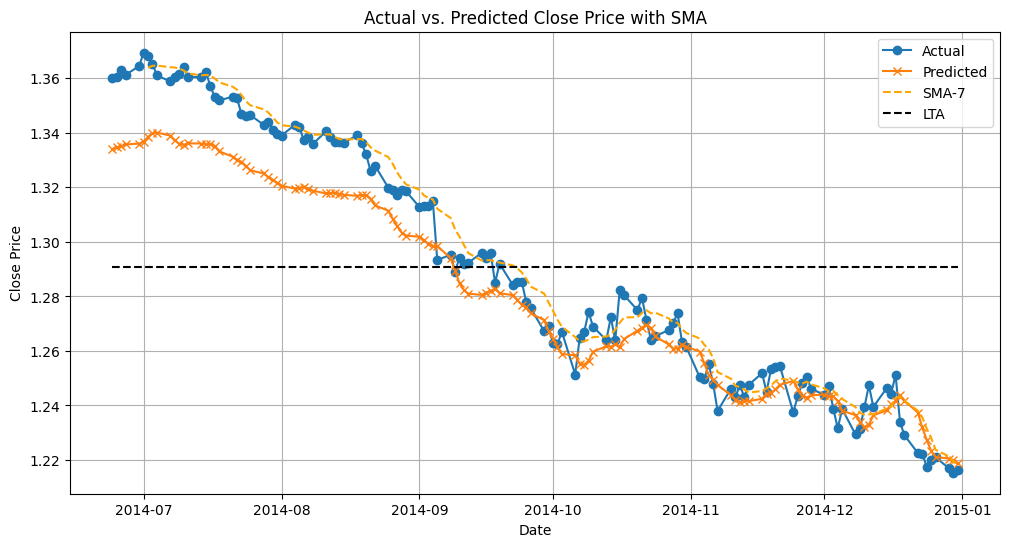

CPU times: user 43min 9s, sys: 15min 33s, total: 58min 43s
Wall time: 37min 29s


In [35]:
%%time

# Set random seed for NumPy (choose any seed value you prefer)
np.random.seed(42)

# Set random seed for TensorFlow (choose any seed value you prefer)
tf.random.set_seed(42)

# Define the number of time steps for the LSTM model
n_steps = 100  # Adjust this value as needed

target_column_name = 'Close'
X, y = split_sequence(df[target_column_name], n_steps)

print(X.shape, y.shape)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define your LSTM model
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model with the best optimizer and learning rate
opt = Adam(learning_rate=0.001)  # Use the best learning rate
model.compile(optimizer=opt, loss='mean_squared_error')

# Summary of the model
model.summary()

# Train the model on X_train and y_train with the best batch size and epochs
model.fit(X_train, y_train, batch_size=1, epochs=20)

# Make predictions for the last month of data
predicted_values = model.predict(X_test)

# Create a DataFrame for the last month of actual and predicted data
last_month_data = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_values.flatten()}, index=df.index[-len(X_test):])

# Calculate the Simple Moving Average (SMA)
sma_window = 7  # Adjust the window size as needed
last_month_data['SMA'] = last_month_data['Actual'].rolling(window=sma_window).mean()
last_month_data['LTA'] = last_month_data['Actual'].mean()

# Plot the actual, predicted, and SMA data
plt.figure(figsize=(12, 6))
plt.plot(last_month_data.index, last_month_data['Actual'], label='Actual', marker='o')
plt.plot(last_month_data.index, last_month_data['Predicted'], label='Predicted', marker='x')
plt.plot(last_month_data.index, last_month_data['SMA'], label=f'SMA-{sma_window}', linestyle='--', color='orange')
plt.plot(last_month_data.index, last_month_data['LTA'], label=f'LTA', linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price with SMA')
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error

In [36]:
mse = mean_squared_error(last_month_data['Actual'], last_month_data['Predicted'])
mse

0.00020603603566081034

Prediction

In [37]:
# Prepare input data for a single time step
# You can use the last n_steps values from your testing data
last_input_sequence = split_sequences_last_n_steps(df[target_column_name].tolist(), n_steps)  # Use the last n_steps values

# Use the trained model to make a prediction
predicted_value = model.predict(last_input_sequence)

# Print the predicted value
print(f"Predicted Value for the Next Time Step: {predicted_value[0][0]}")

1/1 [==============================] - 0s 56ms/step
Predicted Value for the Next Time Step: 1.2183609008789062


Backtrader Simulation

In [39]:
# Download historical data from Yahoo Finance
symbol = "EURUSD=X"
start_date = "2015-01-01"
end_date = "2018-01-01"
data = yfinance.download(symbol, start=start_date, end=end_date)

# Convert the downloaded data to a Backtrader data feed
data = bt.feeds.PandasData(dataname=data)

[*********************100%%**********************]  1 of 1 completed


Strategy

In [44]:
class MyForexStrategy(bt.Strategy):
    params = (
        ("lstm_model", model),  # trained LSTM model
        ("buy_threshold", 0.0),
        ("sell_threshold", 0.0),
        ("initial_balance_eur", 10000),  # Initial balance in EUR
        ("initial_balance_usd", 10000), # Initial balance in USD
        ("last_prediction", 0),
        ("verbose", False),  # Flag to control printing
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predicted_price = None
        self.balance_eur = self.params.initial_balance_eur
        self.balance_usd = self.params.initial_balance_usd
        self.last_prediction = 0
        self.pnl = 0  # Initialize profit/loss to zero

        self.pnlhist = pd.Series()
        self.predicted_price = list()

        # default wait 7 days before making another trade
        self.days = 7
        self.dayCount = 0

    def next(self):
        # set the last prediction to the current close if it is equal to zero
        if self.last_prediction == 0:
            self.last_prediction = self.dataclose[0]
            print("Initial Balance: " + str(self.params.initial_balance_usd / self.dataclose[0] + self.params.initial_balance_eur))

        # only buy/sell once every self.days (default = 7)
        if self.dayCount >= self.days:
            # reset dayCount
            self.dayCount = 0

            # Create a list to store the last 100 close prices
            close_prices = [self.dataclose[i] for i in range(-200, 0)]

            # Create a DataFrame from the list of close prices
            historical_data = close_prices

            # begin loop at 0
            i=0

            # predict the next 10 values
            while i < 10:
                #print(i)
                # reshape historical_data into (x, 100, 1), preparing it for Neural Network's first layer
                #print("historical_data: "+ str(historical_data.shape))
                historical_data_nn_reshape = split_sequence(historical_data, 100)
                #print("historical_data_nn_reshape: "+ str(historical_data_nn_reshape.shape))

                # apply model to current historical_data
                pred_price = self.params.lstm_model.predict(historical_data_nn_reshape)[0][0]
                #print("added to predicted_price = "+ str(pred_price))
                self.predicted_price.append(pred_price)
                i+=1
                #print("added to historical data = "+ str(self.predicted_price))
                historical_data.append(pred_price)

            # calculate the n-Day rolling average price
            nday_rollAvg_price = fmean(self.predicted_price)

            print("nDay Rolling Average Price: " + str(nday_rollAvg_price))
            print("Last Prediction: " + str(self.last_prediction))

            # if it's higher than the last prediction by a certain threshold, sell EUR & buy USD
            if nday_rollAvg_price < self.last_prediction * (1 - self.params.sell_threshold):
                sell_amount_eur = self.balance_eur * 0.25

                # only replace the last prediction if we actually would have made a trade
                self.last_prediction = nday_rollAvg_price

                if sell_amount_eur >= 100:
                    # Convert EUR to USD at the exchange rate and update balances
                    self.balance_usd += sell_amount_eur * self.dataclose[0]
                    self.balance_eur -= sell_amount_eur

                    self.sell(size=sell_amount_eur)

                    print('Closing Exchange Rate: ' + str(self.dataclose[0]))
                    print('Predicted 10-day Rolling Average Closing Exchange Rate: ' + str(nday_rollAvg_price))
                    print(str(self.data.datetime.datetime(0)) + ': Selling EUR - ' + str(sell_amount_eur))
                    #print(str(self.data.datetime.datetime(0)) + ': Current EUR Balance - ' + str(self.balance_eur))
                    #print(str(self.data.datetime.datetime(0)) + ': Current USD Balance - ' + str(self.balance_usd))
                    print(str(self.data.datetime.datetime(0)) + ': Current Total Balance (EUR) - ' + str(self.balance_usd / self.dataclose[0] + self.balance_eur))

                    # Calculate profit/loss for the sell operation
                    self.pnl += (self.balance_usd / self.dataclose[0] + self.balance_eur) - (
                            self.params.initial_balance_usd / self.dataclose[0] + self.params.initial_balance_eur)
                else:
                    print("Sell Amount would be less than 100")

            # if it's lower than the last prediction by a certain threshold, buy EUR & sell USD
            elif nday_rollAvg_price > self.last_prediction * (1 + self.params.buy_threshold):
                # Buy an amount equivalent to 25% of current USD holdings
                buy_amount_usd = self.balance_usd * 0.25

                # only replace the last prediction if we actually would have made a trade
                self.last_prediction = nday_rollAvg_price

                if buy_amount_usd >= 100:
                    # Convert USD to EUR at the exchange rate and update balances
                    self.balance_eur += buy_amount_usd / self.dataclose[0]
                    self.balance_usd -= buy_amount_usd

                    self.buy(size=(buy_amount_usd / self.dataclose[0]))

                    print('Closing Exchange Rate: ' + str(self.dataclose[0]))
                    print('Predicted 10-day Rolling Average Closing Exchange Rate: ' + str(nday_rollAvg_price))
                    print(str(self.data.datetime.datetime(0)) + ': Buying EUR - ' + str(buy_amount_usd))
                    #print(str(self.data.datetime.datetime(0)) + ': Current EUR Balance - ' + str(self.balance_eur))
                    #print(str(self.data.datetime.datetime(0)) + ': Current USD Balance - ' + str(self.balance_usd))
                    print(str(self.data.datetime.datetime(0)) + ': Current Total Balance (EUR) - ' + str(self.balance_usd / self.dataclose[0] + self.balance_eur))

                    # Calculate profit/loss for the buy operation
                    self.pnl += (self.balance_usd / self.dataclose[0] + self.balance_eur) - (
                            self.params.initial_balance_usd / self.dataclose[0] + self.params.initial_balance_eur)
                else:
                    print("Buy Amount would be less than 100")

            # Create a new Series with the pnl value you want to add
            new_pnl_value = pd.Series([self.pnl])

            # Concatenate the new_pnl_value Series with self.pnlhist
            self.pnlhist = pd.concat([self.pnlhist, new_pnl_value])

            print("Current PNL: " + str(self.pnl))

        # days since last trade
        self.dayCount += 1
        print(self.dayCount)

        return self.pnlhist

Analyzer

In [41]:
class MyAnalyzer(bt.Analyzer):
    params = (
        ("initial_balance_eur", 10000),
        ("initial_balance_usd", 10000),
    )

    def __init__(self):
        self.pnl = []  # List to store daily P&L values

    def start(self):
        # Initialize P&L with the initial balance
        self.pnl.append(self.params.initial_balance_eur + self.params.initial_balance_usd / self.strategy.dataclose[0])

    def notify_order(self, order):
        if order.status in [order.Completed]:
            # Calculate P&L after each completed order
            self.pnl.append(self.strategy.balance_eur + self.strategy.balance_usd / self.strategy.dataclose[0])

    def get_analysis(self):
        return {"pnl": self.pnl}

Simulation

In [49]:
%%time

if __name__ == "__main__":
    # Initialize and run the Backtrader engine with your data
    cerebro = bt.Cerebro(optreturn=False, optdatas=True)

    # Add data and strategy
    cerebro.adddata(data)
    my_strategy = MyForexStrategy  # Replace this with your strategy
    cerebro.addstrategy(my_strategy, lstm_model=model)

    # Add the custom analyzer to cerebro
    cerebro.addanalyzer(MyAnalyzer, _name="myanalyzer")

    # Run the backtest
    cerebro.run()

Initial Balance: 18265.399817618665
1
2
3
4
5
6
7


<ipython-input-44-2b6b3bb2caa0>:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.pnlhist = pd.Series()


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float32>]


In [ ]:
# Access the analyzer results
analyzer_results = cerebro.runstrats[0][0].analyzers.myanalyzer.get_analysis()
pnlhist = pd.Series(analyzer_results["pnl"])

In [ ]:
# Assuming you already have pnlhist as your Pandas Series
initial_balance = pnlhist.iloc[0]  # Initial balance
final_balance = pnlhist.iloc[-1]  # Final balance

# Plotting the P&L data
plt.figure(figsize=(18, 2))
plt.plot(pnlhist.index, pnlhist.values, label='P&L', color='blue')

# Adding a white background bounding box for the initial and final balance labels with reduced opacity
bbox_props = dict(boxstyle='round,pad=0.3', edgecolor='green', facecolor='white', alpha=1)  # Adjust alpha here

# Initial balance label
plt.annotate(f'Initial Balance: ${initial_balance:.2f}', (pnlhist.index[0], initial_balance),
             textcoords='offset points', xytext=(10, 10), fontsize=12,
             bbox=bbox_props, color='green')

# Final balance label
plt.annotate(f'Final Balance: ${final_balance:.2f}', (pnlhist.index[-1], final_balance),
             textcoords='offset points', xytext=(10, 10), fontsize=12,
             bbox=bbox_props, color='red')

# Adding a trend line (linear regression line)
x = np.arange(len(pnlhist))
coefficients = np.polyfit(x, pnlhist.values, 1)
trend_line = np.poly1d(coefficients)
plt.plot(pnlhist.index, trend_line(x), label='Trend Line', color='orange')

plt.xlabel('Date')
plt.ylabel('P&L')
plt.title('Strategy P&L Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 8]

print(cerebro.observers)

# Run the Backtrader engine without plotting
cerebro.plot(iplot=False)